SimpleGNN with only rotation augmentation.

In [1]:
!rm -rf /kaggle/working/p30gnn
#!rm -rf /kaggle/working/*
!git clone -b data-augmentation --single-branch \
https://github.com/oskareriksandelin/p30gnn.git

Cloning into 'p30gnn'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 219 (delta 32), reused 56 (delta 26), pack-reused 136 (from 1)
Receiving objects: 100% (219/219), 1.39 MiB | 7.66 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
!pip install torch_geometric

In [3]:
!pwd
!ls


/kaggle/working
best_model.pt  data  p30gnn


## LOAD THE DATA

In [4]:
!pip -q install gdown   

In [5]:
import gdown

In [6]:
folder_url = "https://drive.google.com/drive/folders/1y10KJqDBL5RhETXMChe48e93Q0oubGHn?usp=drive_link"
gdown.download_folder(folder_url, output="data", quiet=False, remaining_ok=True)

Retrieving folder contents


Processing file 19HVQoNILBqnfv7vvSdcTXirFptHNVlVX FeGd_data_POSCAR_2.zip
Processing file 15lcB99k6cYbt0HGnQj_g8QXtb3N2nCFT FeGd_data_POSCAR_3.zip
Processing file 1f__wyGmIioGC9WfimVaypb6HrmuJ06vq FeGd_data_POSCAR_4.zip
Processing file 1OmYIMRib6yYpWmxcagvhKVUVHJfoiVwh FeGd_data_POSCAR_5.zip
Processing file 1x71MDnwVG6QQ4Nm9Gan6Y2uUo3TDoIFG FeGd_data_POSCAR_6.zip
Processing file 1F4OvZB1U2P1OEOxvGdr_-6CnbpVpjrRi FeGd_data_POSCAR_7.zip
Processing file 1ybzjthY_8ZHUOzcjQ62Du9v24EW4Azct FeGd_data_POSCAR_8.zip
Processing file 1baE5wY5rFIQERD0l2tJFBK2vCtyQ2c5x FeGd_data_POSCAR_9.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=19HVQoNILBqnfv7vvSdcTXirFptHNVlVX
From (redirected): https://drive.google.com/uc?id=19HVQoNILBqnfv7vvSdcTXirFptHNVlVX&confirm=t&uuid=fe5b9757-bda1-4f26-8b13-7b9d2e3753b9
To: /kaggle/working/data/FeGd_data_POSCAR_2.zip
100%|██████████| 278M/278M [00:01<00:00, 176MB/s]  
Downloading...
From (original): https://drive.google.com/uc?id=15lcB99k6cYbt0HGnQj_g8QXtb3N2nCFT
From (redirected): https://drive.google.com/uc?id=15lcB99k6cYbt0HGnQj_g8QXtb3N2nCFT&confirm=t&uuid=c024631f-d929-405f-a637-d988ca2148ff
To: /kaggle/working/data/FeGd_data_POSCAR_3.zip
100%|██████████| 34.7M/34.7M [00:00<00:00, 102MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1f__wyGmIioGC9WfimVaypb6HrmuJ06vq
From (redirected): https://drive.google.com/uc?id=1f__wyGmIioGC9WfimVaypb6HrmuJ06vq&confirm=t&uuid=395ff1f6-192a-4283-9c42-00c6f28c

['data/FeGd_data_POSCAR_2.zip',
 'data/FeGd_data_POSCAR_3.zip',
 'data/FeGd_data_POSCAR_4.zip',
 'data/FeGd_data_POSCAR_5.zip',
 'data/FeGd_data_POSCAR_6.zip',
 'data/FeGd_data_POSCAR_7.zip',
 'data/FeGd_data_POSCAR_8.zip',
 'data/FeGd_data_POSCAR_9.zip']

In [7]:
!pwd
!ls

/kaggle/working
best_model.pt  data  p30gnn


In [8]:
!ls data

FeGd_data_POSCAR_2	FeGd_data_POSCAR_5	FeGd_data_POSCAR_8
FeGd_data_POSCAR_2.zip	FeGd_data_POSCAR_5.zip	FeGd_data_POSCAR_8.zip
FeGd_data_POSCAR_3	FeGd_data_POSCAR_6	FeGd_data_POSCAR_9
FeGd_data_POSCAR_3.zip	FeGd_data_POSCAR_6.zip	FeGd_data_POSCAR_9.zip
FeGd_data_POSCAR_4	FeGd_data_POSCAR_7
FeGd_data_POSCAR_4.zip	FeGd_data_POSCAR_7.zip


In [9]:
import zipfile
from pathlib import Path

data_path = Path("/kaggle/working/data")

for z in data_path.glob("*.zip"):
    with zipfile.ZipFile(z) as f:
        f.extractall(data_path)
    z.unlink()  # remove the zip file

In [10]:
!ls data

FeGd_data_POSCAR_2  FeGd_data_POSCAR_4	FeGd_data_POSCAR_6  FeGd_data_POSCAR_8
FeGd_data_POSCAR_3  FeGd_data_POSCAR_5	FeGd_data_POSCAR_7  FeGd_data_POSCAR_9


## Load the data

In [11]:
from p30gnn.FeGdSpinGNN.utils import normalize_data, compute_normalization_stats
from p30gnn.FeGdSpinGNN.augmentation import RandomRotationTransform
from p30gnn.FeGdSpinGNN.FeGd_dataset import FeGdMagneticDataset


In [ ]:
# Data augmentation: random rotations
rotation_transform = RandomRotationTransform
cut_off = 0.25

train_dataset = FeGdMagneticDataset(data_path, systems=[2, 3, 4, 5], cutoff_dist=cut_off, transform_rotate=rotation_transform)
val_dataset = FeGdMagneticDataset(data_path, systems=[6, 7], cutoff_dist=cut_off)
test_dataset = FeGdMagneticDataset(data_path, systems=[8, 9], cutoff_dist=cut_off)

Loading systems: 100%|██████████| 2/2 [00:09<00:00,  4.56s/it]


In [14]:
def normalize_dataset(dataset, stats):
    normalized_list = [None]*len(dataset)
    for i, data in enumerate(dataset):
        normalized_list[i] = (normalize_data(data, stats))
    return normalized_list

# compute normalization stats
norm_stats = compute_normalization_stats(train_dataset)

train_data_norm = normalize_dataset(train_dataset, norm_stats)
val_data_norm = normalize_dataset(val_dataset, norm_stats)
test_data_norm = normalize_dataset(test_dataset, norm_stats)

# Model - augmented data

In [15]:
from p30gnn.FeGdSpinGNN.utils import normalize_data, compute_normalization_stats
from p30gnn.FeGdSpinGNN.FeGd_dataset import FeGdMagneticDataset

from p30gnn.FeGdSpinGNN.models import SimpleGNNModel
from p30gnn.FeGdSpinGNN.utils import train_one_epoch, evaluate

import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from time import time

In [17]:
# --- DATALOADERS ---
train_loader = DataLoader(train_data_norm, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data_norm,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data_norm,  batch_size=32, shuffle=False)

# --- MODEL ---

# Hyperparameters
hidden_dim = 32
num_layers = 5
dropout = 0.2
lr=1e-4
weight_decay=5e-3
num_epochs = 40

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

model = SimpleGNNModel(
    input_dim=5, 
    hidden_dim=64, 
    output_dim=3, 
    num_layers=3, 
    edge_dim=4
    ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=10,
    factor=0.5,
    min_lr=1e-6
)

# --- TRAINING ---
best_val_loss = float('inf')
train_losses = []
val_losses = []
start_time = time()
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss   = evaluate(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"{epoch}/{num_epochs}   Train loss: {train_loss:.6f}    Val loss: {val_loss:.6f}    LR: {optimizer.param_groups[0]['lr']:.6f}")

    scheduler.step(val_loss)

    # save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")

train_time = time() - start_time
print(f"Training time: {train_time/60:.2f} minutes")


Using device: cuda


1/40   Train loss: 0.749258    Val loss: 0.773037    LR: 0.000100


2/40   Train loss: 0.446880    Val loss: 0.557648    LR: 0.000100


3/40   Train loss: 0.362064    Val loss: 0.466784    LR: 0.000100


4/40   Train loss: 0.310829    Val loss: 0.418723    LR: 0.000100


5/40   Train loss: 0.282511    Val loss: 0.373344    LR: 0.000100


6/40   Train loss: 0.267075    Val loss: 0.323295    LR: 0.000100


7/40   Train loss: 0.262379    Val loss: 0.305687    LR: 0.000100


8/40   Train loss: 0.253295    Val loss: 0.301018    LR: 0.000100


9/40   Train loss: 0.252481    Val loss: 0.293570    LR: 0.000100


10/40   Train loss: 0.250834    Val loss: 0.277904    LR: 0.000100


11/40   Train loss: 0.248158    Val loss: 0.277330    LR: 0.000100


12/40   Train loss: 0.243783    Val loss: 0.259677    LR: 0.000100


13/40   Train loss: 0.245418    Val loss: 0.260410    LR: 0.000100


14/40   Train loss: 0.240364    Val loss: 0.257966    LR: 0.000100


15/40   Train loss: 0.239836    Val loss: 0.266246    LR: 0.000100


16/40   Train loss: 0.243130    Val loss: 0.276974    LR: 0.000100


17/40   Train loss: 0.239879    Val loss: 0.246425    LR: 0.000100


18/40   Train loss: 0.240386    Val loss: 0.247335    LR: 0.000100


19/40   Train loss: 0.239031    Val loss: 0.264951    LR: 0.000100


20/40   Train loss: 0.236332    Val loss: 0.259199    LR: 0.000100


21/40   Train loss: 0.235259    Val loss: 0.263569    LR: 0.000100


22/40   Train loss: 0.236160    Val loss: 0.256033    LR: 0.000100


23/40   Train loss: 0.233824    Val loss: 0.250415    LR: 0.000100


24/40   Train loss: 0.231016    Val loss: 0.272898    LR: 0.000100


25/40   Train loss: 0.233937    Val loss: 0.255127    LR: 0.000100


26/40   Train loss: 0.234011    Val loss: 0.248882    LR: 0.000100


27/40   Train loss: 0.234398    Val loss: 0.263356    LR: 0.000100


28/40   Train loss: 0.231291    Val loss: 0.266819    LR: 0.000100


29/40   Train loss: 0.229632    Val loss: 0.256212    LR: 0.000050


30/40   Train loss: 0.230218    Val loss: 0.254797    LR: 0.000050


31/40   Train loss: 0.231049    Val loss: 0.240436    LR: 0.000050


32/40   Train loss: 0.230750    Val loss: 0.270621    LR: 0.000050


33/40   Train loss: 0.226665    Val loss: 0.261825    LR: 0.000050


34/40   Train loss: 0.227575    Val loss: 0.261142    LR: 0.000050


35/40   Train loss: 0.227748    Val loss: 0.253965    LR: 0.000050


36/40   Train loss: 0.229038    Val loss: 0.257772    LR: 0.000050


37/40   Train loss: 0.226514    Val loss: 0.250351    LR: 0.000050


38/40   Train loss: 0.225339    Val loss: 0.248286    LR: 0.000050


39/40   Train loss: 0.227479    Val loss: 0.258570    LR: 0.000050


40/40   Train loss: 0.225518    Val loss: 0.248693    LR: 0.000050
Training time: 2.29 minutes


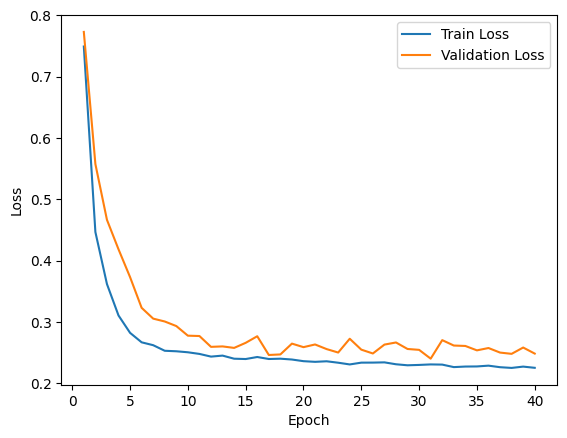

In [18]:
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# --- TEST EVALUATION ---

model.load_state_dict(torch.load("best_model.pt"))
test_loss = evaluate(model, test_loader, device)

print(f"\nFinal Test Loss: {test_loss:.6f}")


Final Test Loss: 0.141085


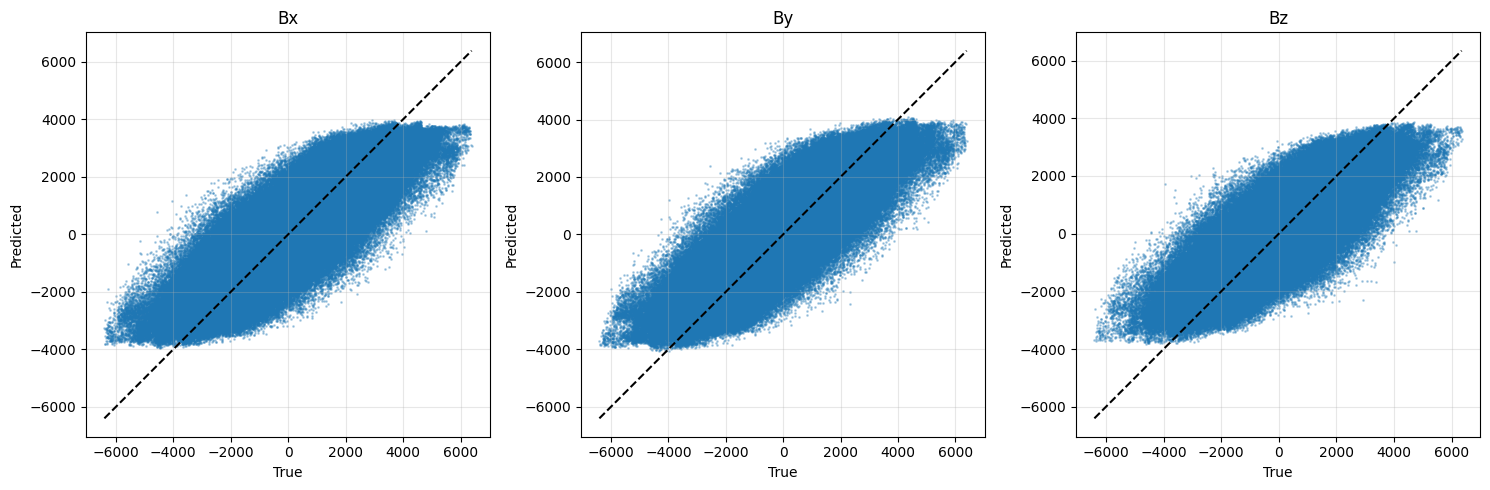

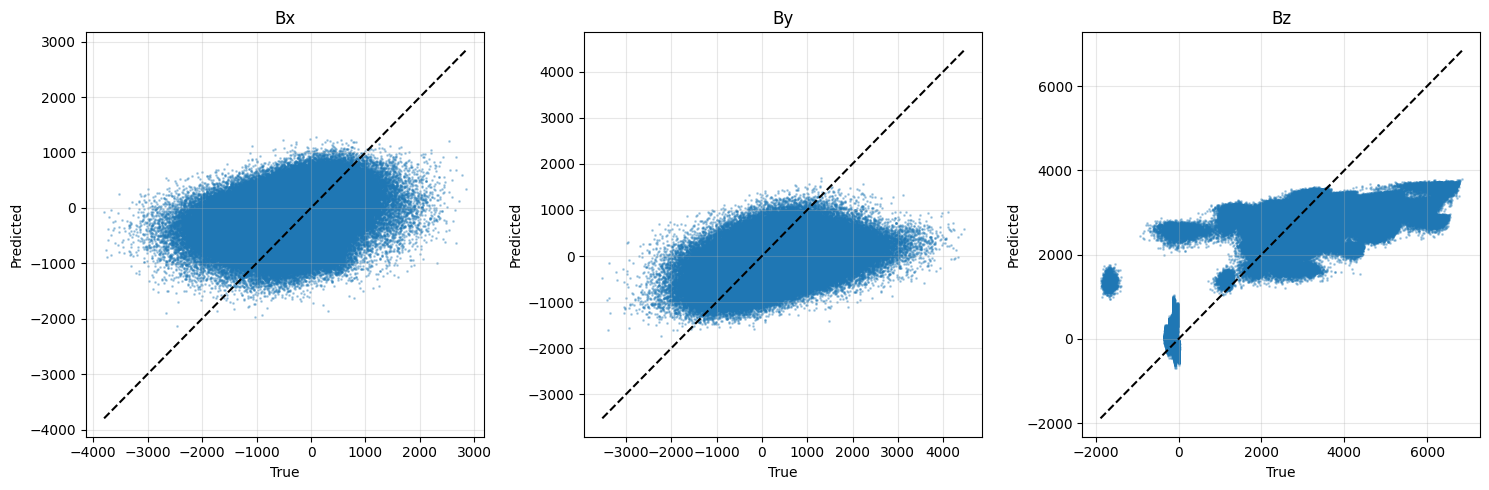

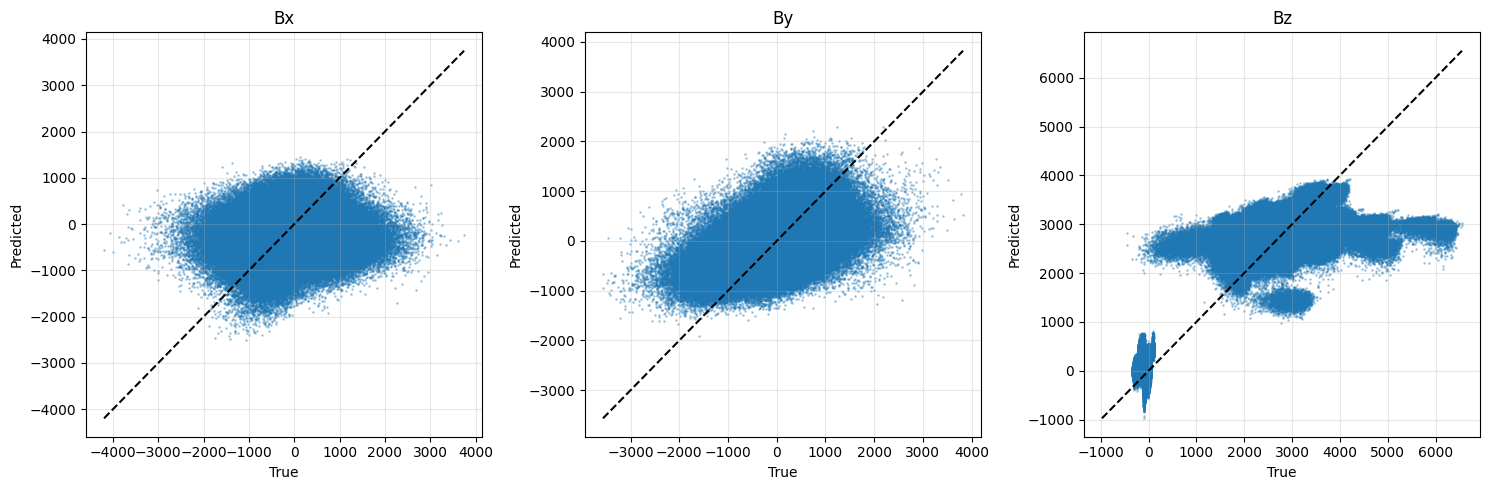

In [20]:
from p30gnn.FeGdSpinGNN.plots import plot_correlation
plot_correlation(model, train_loader, device, norm_stats['target_mean'], norm_stats['target_std'])
plot_correlation(model, val_loader, device, norm_stats['target_mean'], norm_stats['target_std'])
plot_correlation(model, test_loader, device, norm_stats['target_mean'], norm_stats['target_std'])

In [21]:
from p30gnn.FeGdSpinGNN.utils import evaluate_physical_metrics


In [23]:
evaluate_physical_metrics(model, test_loader, device, norm_stats['target_mean'], norm_stats['target_std'])

{'mse': 361312.34375,
 'rmse': 601.0926513671875,
 'mae': 428.338623046875,
 'mse_x': 379893.90625,
 'mse_y': 265207.09375,
 'mse_z': 438836.09375}